In [3]:
import time
from collections import deque

# -------- Image processing -----
import pyautogui
import numpy as np
import cv2

# -------- TensorFlow / Keras ----
import tensorflow as tf
from tensorflow.keras import layers, Model

# -------- Misc / Debug ----------
import matplotlib.pyplot as plt



In [4]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[]


In [5]:
#Establish some variables and params for later
FRAME_STACK = 4


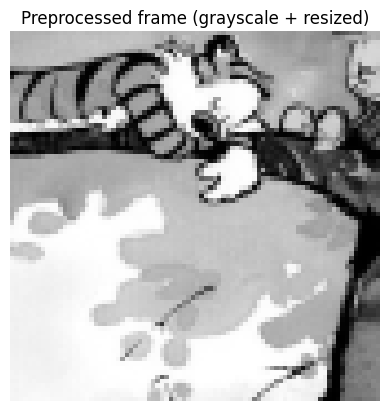

In [6]:
def preprocess_frame(image, resize=(84, 84), gray=True):
    """
    Captures a screenshot of the given region, converts to grayscale, resizes.
    Returns numpy array of shape (resize[1], resize[0]).
    """
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize deterministically
    small = cv2.resize(image, resize, interpolation=cv2.INTER_AREA)
    
    return small

def stack_frames(frames, new_frame, stack_size=FRAME_STACK):
    """
    Maintains a stack of frames to capture motion.
    frames: deque of previous frames
    new_frame: newest preprocessed frame
    Returns stack of frames
    """
    if len(frames) == 0:
        # Initialize with repeated frame
        for _ in range(stack_size):
            frames.append(new_frame)
    else:
        frames.append(new_frame)
        if len(frames) > stack_size:
            frames.popleft()
    return np.stack(frames, axis=0)

#TEST to see if screen grab is working
time.sleep(3)
screenshot = pyautogui.screenshot(region=(450, 120, 540, 730))
img = cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)
processed = preprocess_frame(img)
plt.imshow(processed, cmap="gray")
plt.title("Preprocessed frame (grayscale + resized)")
plt.axis("off")
plt.show()